In [15]:
pip install matplotlib seaborn

In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Load ratings and movie info
ratings = pd.read_csv('u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
movies = pd.read_csv('u.item', sep='|', encoding='latin-1', header=None,
                     names=['movie_id', 'title'], usecols=[0, 1])

# Merge ratings with movie titles
data = pd.merge(ratings, movies, left_on='item_id', right_on='movie_id')

In [18]:
user_item_matrix = data.pivot_table(index='user_id', columns='title', values='rating')
user_item_matrix.fillna(0, inplace=True)

In [19]:
def get_user_similarity_matrix(matrix):
    return pd.DataFrame(cosine_similarity(matrix), index=matrix.index, columns=matrix.index)

user_similarity = get_user_similarity_matrix(user_item_matrix)

In [20]:
item_item_matrix = user_item_matrix.T  # transpose to get item-user matrix
item_similarity = pd.DataFrame(cosine_similarity(item_item_matrix), index=item_item_matrix.index, columns=item_item_matrix.index)

def recommend_item_based(user_id, matrix, similarity_matrix, top_n=10, return_scores=False):
    user_ratings = matrix.loc[user_id]
    scores = similarity_matrix @ user_ratings
    scores = scores / similarity_matrix.sum(axis=1)

    unseen = user_ratings[user_ratings == 0]
    recommendations = scores[unseen.index].sort_values(ascending=False).head(top_n)

    return recommendations if return_scores else recommendations.index.tolist()

In [21]:
def recommend_svd(user_id, matrix, n_components=20, top_n=10, return_scores=False):
    svd = TruncatedSVD(n_components=n_components)
    latent_matrix = svd.fit_transform(matrix)
    reconstructed_matrix = np.dot(latent_matrix, svd.components_)

    user_row = reconstructed_matrix[user_id - 1]
    user_rated = matrix.loc[user_id]
    unseen = user_rated[user_rated == 0]

    preds = pd.Series(user_row, index=matrix.columns)
    recommendations = preds[unseen.index].sort_values(ascending=False).head(top_n)

    return recommendations if return_scores else recommendations.index.tolist()

In [22]:
def recommend_user_based(user_id, matrix, similarity_matrix, top_n=10):
    sim_scores = similarity_matrix.loc[user_id].drop(user_id)

    other_users_matrix = matrix.loc[sim_scores.index]

    weighted_scores = sim_scores.values @ other_users_matrix.values
    weighted_scores_series = pd.Series(weighted_scores, index=matrix.columns)

    user_seen = matrix.loc[user_id]
    unseen_movies = user_seen[user_seen == 0]

    recommendations = weighted_scores_series[unseen_movies.index].sort_values(ascending=False).head(top_n)
    return recommendations.index.tolist()

In [23]:
def precision_at_k(predicted_list, actual_list, k=10):

    predicted_at_k = predicted_list[:k]
    relevant_items = set(predicted_at_k).intersection(set(actual_list))
    precision = len(relevant_items) / k
    return round(precision, 4)

In [24]:
sample_user = 5
actual_liked = data[(data['user_id'] == sample_user) & (data['rating'] >= 4)]['title'].tolist()

rec_user = recommend_user_based(sample_user, user_item_matrix, user_similarity, top_n=10)
rec_item = recommend_item_based(sample_user, user_item_matrix, item_similarity, top_n=10)
rec_svd  = recommend_svd(sample_user, user_item_matrix, top_n=10)

print("Precision@10 (User-based):", precision_at_k(rec_user, actual_liked))
print("Precision@10 (Item-based):", precision_at_k(rec_item, actual_liked))
print("Precision@10 (SVD):", precision_at_k(rec_svd, actual_liked))

Precision@10 (User-based): 0.0
Precision@10 (Item-based): 0.0
Precision@10 (SVD): 0.0


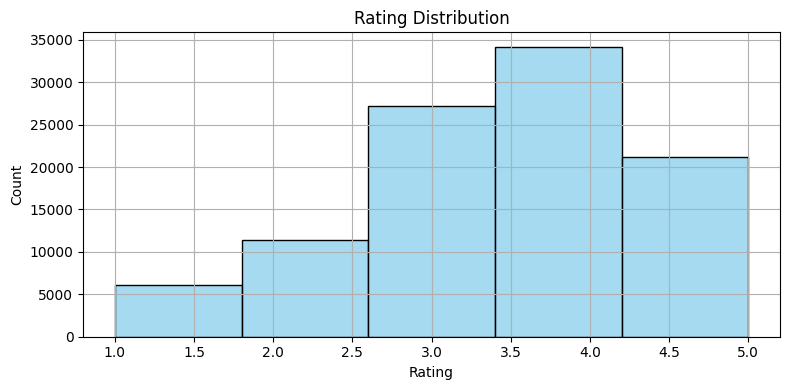

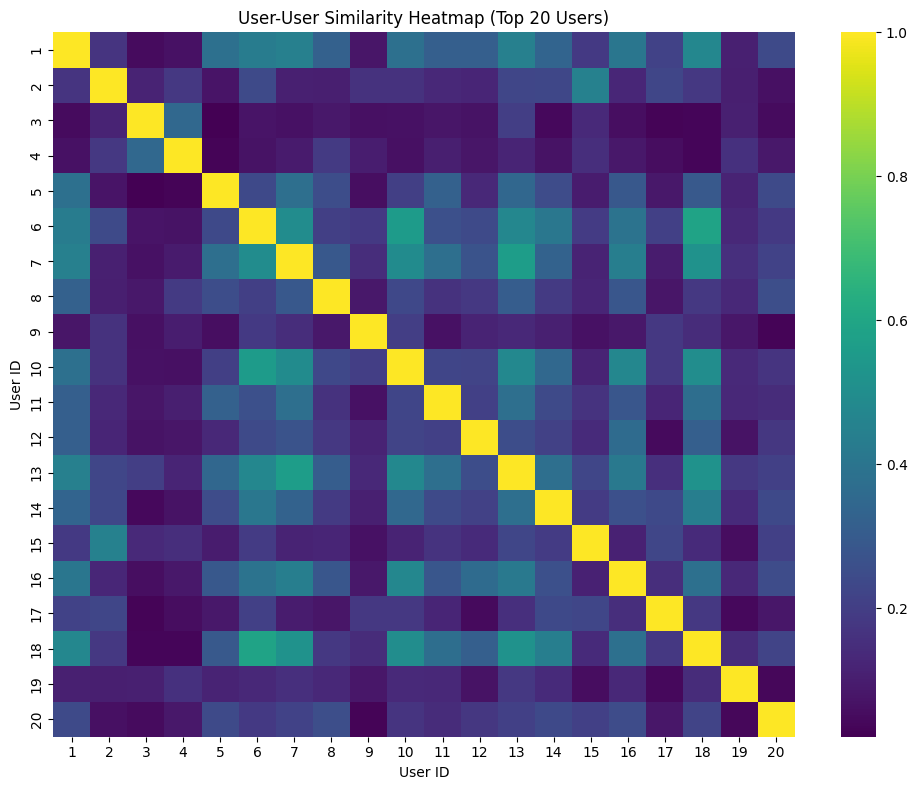

/tmp/ipython-input-26-1855585653.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rec_list.values, y=rec_list.index, palette='coolwarm')


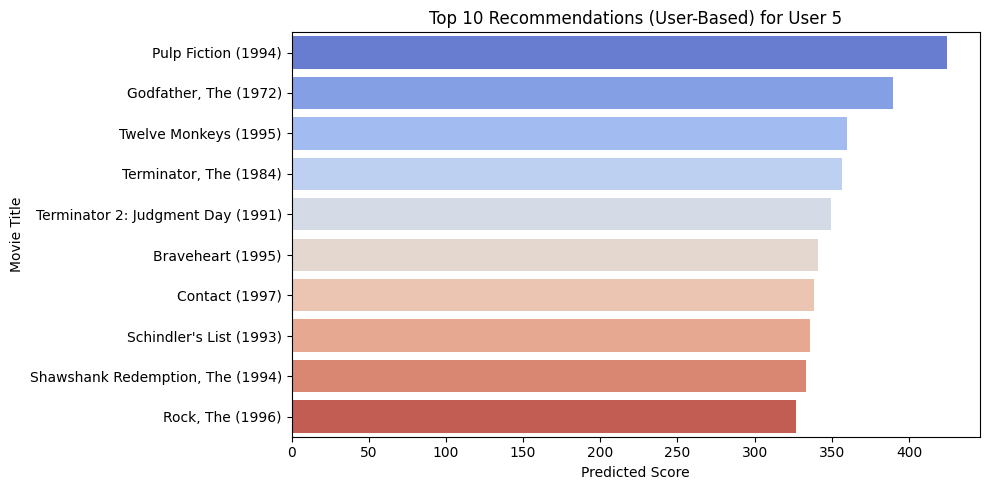

/tmp/ipython-input-26-1855585653.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rec_list.values, y=rec_list.index, palette='coolwarm')


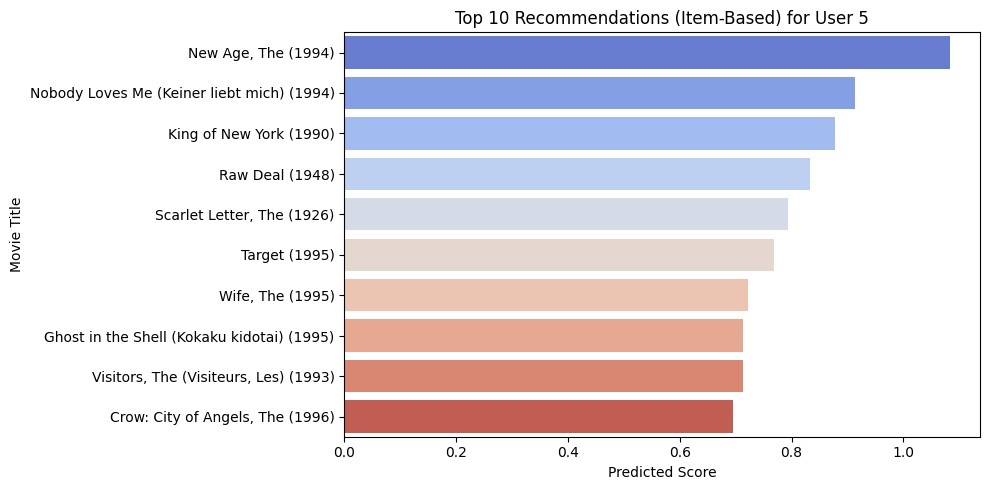

/tmp/ipython-input-26-1855585653.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rec_list.values, y=rec_list.index, palette='coolwarm')


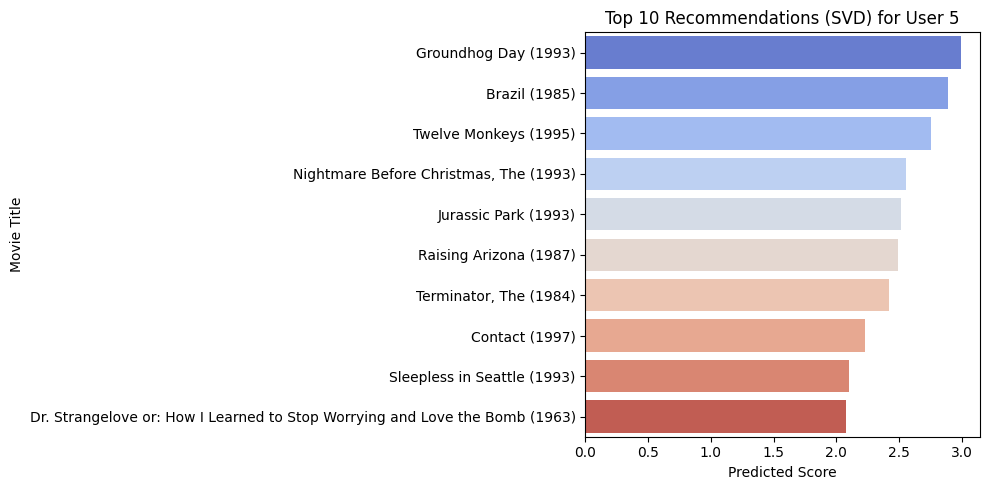

In [26]:
# Visualize Rating Distribution
plt.figure(figsize=(8, 4))
sns.histplot(data['rating'], bins=5, kde=False, color='skyblue')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize User Similarity Matrix (heatmap of 20 users)
plt.figure(figsize=(10, 8))
subset_users = user_similarity.iloc[:20, :20]
sns.heatmap(subset_users, cmap='viridis', annot=False)
plt.title('User-User Similarity Heatmap (Top 20 Users)')
plt.xlabel('User ID')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()

# Visualize Top-N Recommendations for a Sample User
def plot_top_n_recommendations(rec_list, title, model_name):
    plt.figure(figsize=(10, 5))
    sns.barplot(x=rec_list.values, y=rec_list.index, palette='coolwarm')
    plt.title(f'Top {len(rec_list)} Recommendations ({model_name}) for {title}')
    plt.xlabel('Predicted Score')
    plt.ylabel('Movie Title')
    plt.tight_layout()
    plt.show()

# Get recommendation scores for plotting (change recommend_* functions to return scores)
def recommend_user_based_scores(user_id, matrix, similarity_matrix, top_n=10):
    sim_scores = similarity_matrix.loc[user_id].drop(user_id)
    other_users_matrix = matrix.loc[sim_scores.index]
    weighted_scores = sim_scores.values @ other_users_matrix.values
    weighted_scores_series = pd.Series(weighted_scores, index=matrix.columns)
    user_seen = matrix.loc[user_id]
    unseen_movies = user_seen[user_seen == 0]
    recommendations = weighted_scores_series[unseen_movies.index].sort_values(ascending=False).head(top_n)
    return recommendations

# Plot for each method
rec_user_scores = recommend_user_based_scores(sample_user, user_item_matrix, user_similarity)
rec_item_scores = recommend_item_based(sample_user, user_item_matrix, item_similarity, top_n=10, return_scores=True)
rec_svd_scores  = recommend_svd(sample_user, user_item_matrix, top_n=10, return_scores=True)

plot_top_n_recommendations(rec_user_scores, f'User {sample_user}', 'User-Based')
plot_top_n_recommendations(rec_item_scores, f'User {sample_user}', 'Item-Based')
plot_top_n_recommendations(rec_svd_scores, f'User {sample_user}', 'SVD')